### **Import Packages/Load Data/Function Definitions**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb



import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/spanish_wines.csv')
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [4]:
def eval_classification(true, pred, name='Model', average='macro'):
      
    print(name, '\n')
    print(classification_report(true, pred))
    ConfusionMatrixDisplay.from_predictions(true, pred)
    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred, average=average)]
    scores['Recall'] = [recall_score(true, pred, average=average)]
    scores['F1 Score'] = [f1_score(true, pred, average=average)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

### **Data Cleaning**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


In [6]:
# drop dupllicates
df = df.drop_duplicates()

In [7]:
# dropping the 'wine' column due to high cardinality
# dropping the 'country' column as all the values are the same
df = df.drop(columns=['country', 'wine'])
df = df.dropna(subset=['type'])

In [8]:
# handling error
df['year'] = df['year'].replace('N.V.', np.nan)
df.dropna(subset=['year'], inplace=True)

In [9]:
df['year'] = df['year'].astype('int')

In [10]:
# cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1877 entries, 0 to 6100
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       1877 non-null   object 
 1   year         1877 non-null   int32  
 2   rating       1877 non-null   float64
 3   num_reviews  1877 non-null   int64  
 4   region       1877 non-null   object 
 5   price        1877 non-null   float64
 6   type         1877 non-null   object 
 7   body         1714 non-null   float64
 8   acidity      1714 non-null   float64
dtypes: float64(4), int32(1), int64(1), object(3)
memory usage: 139.3+ KB


### **Analyzing Numerical and Categorical Columns**

In [11]:
# previewing numerical columns 
df.describe()

,year,rating,num_reviews,price,body,acidity
count,1877.000000,1877.000000,1877.000000,1877.000000,1714.000000,1714.000000
mean,2010.869473,4.404688,579.998934,142.612586,4.263127,2.928238
std,11.300344,0.148552,1181.990378,282.560181,0.660949,0.313328
min,1910.000000,4.200000,25.000000,6.260000,2.000000,1.000000
25%,2010.000000,4.300000,60.000000,32.550000,4.000000,3.000000
50%,2015.000000,4.400000,151.000000,55.140000,4.000000,3.000000
75%,2017.000000,4.500000,513.000000,117.300000,5.000000,3.000000
max,2021.000000,4.900000,16505.000000,3119.080000,5.000000,3.000000


In [12]:
# previewing categorical columns
df.describe(exclude='number')

,winery,region,type
count,1877,1877,1877
unique,410,65,21
top,Vega Sicilia,Ribera del Duero,Ribera Del Duero Red
freq,96,538,534


### **Feature Engineering**

In [13]:
# the results of the cell below shows the percentages of each vintage in our dataset
year_full = df['year'].value_counts(normalize=True).reset_index()


with pd.option_context('display.max_rows', None):
    print(year_full)

    index      year
0    2016  0.125733
1    2017  0.118807
2    2015  0.106553
3    2018  0.093767
4    2014  0.083644
5    2011  0.051678
6    2012  0.049014
7    2019  0.048482
8    2010  0.039425
9    2013  0.034630
10   2009  0.024507
11   2007  0.020245
12   2004  0.019180
13   2005  0.019180
14   2006  0.015983
15   2008  0.015983
16   2001  0.011188
17   2020  0.009590
18   2000  0.009057
19   2003  0.006926
20   1994  0.006926
21   1995  0.006926
22   1998  0.006393
23   2002  0.006393
24   1996  0.005860
25   1999  0.005328
26   1982  0.004262
27   1985  0.003729
28   1989  0.003729
29   1986  0.003197
30   1964  0.003197
31   2021  0.003197
32   1968  0.002664
33   1987  0.002664
34   1970  0.002664
35   1981  0.002131
36   1973  0.001598
37   1997  0.001598
38   1991  0.001598
39   1980  0.001066
40   1959  0.001066
41   1988  0.001066
42   1975  0.001066
43   1965  0.001066
44   1990  0.001066
45   1955  0.001066
46   1983  0.001066
47   1979  0.001066
48   1946  0.001066


In [14]:
# a new dataframe is created for the all the data after the year 2002 
df_filtered = df.loc[df['year'] >= 2002]
df_filtered.head()

,winery,year,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,2013,4.9,58,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,2018,4.9,31,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,2009,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
6,Vega Sicilia,2010,4.8,1201,Ribera del Duero,349.00,Ribera Del Duero Red,5.0,3.0
8,Vega Sicilia,2015,4.8,643,Ribera del Duero,345.00,Ribera Del Duero Red,5.0,3.0


In [15]:
# converting the 'rating' column into 3 separate classes
df_filtered['rating'] = df_filtered['rating'].apply(lambda x: 'low' if 4.2 <= x <= 4.4 else ('med' if 4.5 <= x <= 4.6 else 'high'))

In [17]:
df_filtered['year'] = df_filtered['year'].astype('category')

### **Preprocessing**

In [18]:
# instantiate imputers // creatintg pipelines
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

num_selector = make_column_selector(dtype_include=['number','float'])
cat_selector = make_column_selector(dtype_include=['object','category'])

num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

preprocessor = make_column_transformer((num_pipe, num_selector), (cat_pipe, cat_selector))

### **Initial Modeling and Evaluating**

In [19]:
# selecting vector(y) and features(X)
y = df_filtered['rating']
X = df_filtered.drop(columns='rating')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Logistic Regression 

              precision    recall  f1-score   support

        high       0.60      0.30      0.40        20
         low       0.79      0.96      0.87       293
         med       0.60      0.31      0.41       106

    accuracy                           0.76       419
   macro avg       0.66      0.52      0.56       419
weighted avg       0.74      0.76      0.73       419



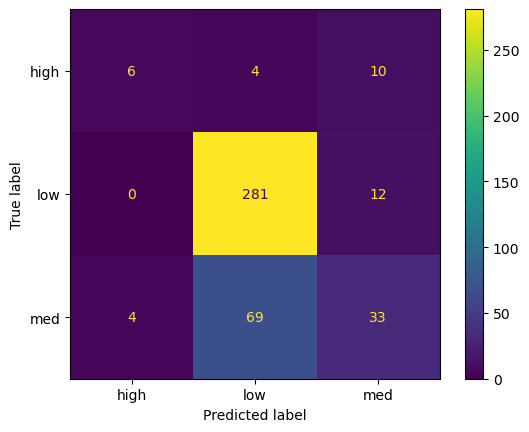

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Logistic Regression,0.664595,0.523455,0.559521,0.763723


In [25]:
# model 1: logistic regressor
log_reg = LogisticRegression(max_iter=1000)
log_reg_pipe = make_pipeline(preprocessor, log_reg)
log_reg_pipe.fit(X_train, y_train)
log_reg_y_pred = log_reg_pipe.predict(X_test)

# evaluate logistic regression model
model_scores_log_reg = eval_classification(y_test, log_reg_y_pred, name='Logistic Regression')
model_scores_log_reg

K-Nearest Neighbors 

              precision    recall  f1-score   support

        high       0.50      0.55      0.52        20
         low       0.81      0.91      0.86       293
         med       0.57      0.36      0.44       106

    accuracy                           0.75       419
   macro avg       0.63      0.61      0.61       419
weighted avg       0.73      0.75      0.74       419



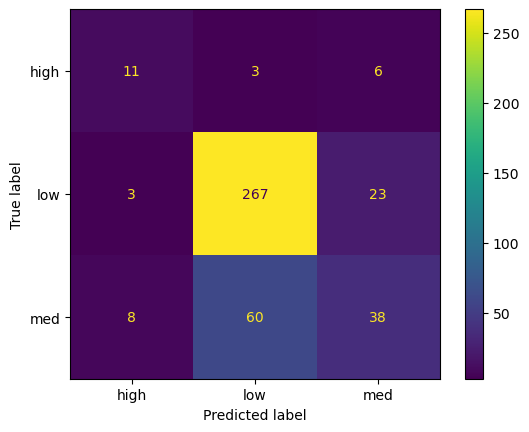

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
K-Nearest Neighbors,0.625418,0.606584,0.606753,0.754177


In [26]:
# model 2: K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)
y_pred_knn = knn_pipe.predict(X_test)

# evaluate KNN model
model_scores_knn = eval_classification(y_test, y_pred_knn, name='K-Nearest Neighbors', average='macro')
model_scores_knn

Decision Tree Classifier 

              precision    recall  f1-score   support

        high       0.50      0.45      0.47        20
         low       0.81      0.88      0.85       293
         med       0.49      0.39      0.43       106

    accuracy                           0.74       419
   macro avg       0.60      0.57      0.59       419
weighted avg       0.72      0.74      0.73       419



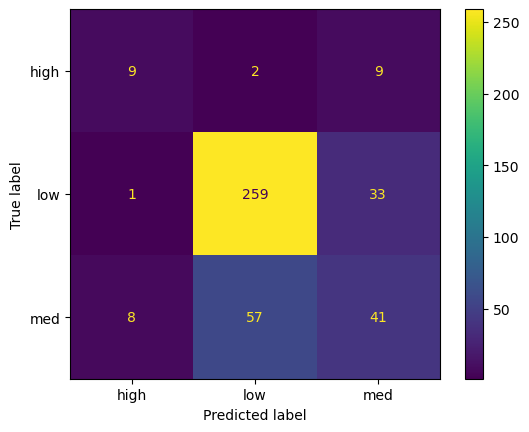

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Decision Tree Classifier,0.602814,0.573584,0.585112,0.73747


In [28]:
# model 3: decision tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt_pipe = make_pipeline(preprocessor, dt)
dt_pipe.fit(X_train, y_train)
y_pred_dt = dt_pipe.predict(X_test)

# evaluate the decision tree classifier
model_scores_dt = eval_classification(y_test, y_pred_dt, name='Decision Tree Classifier', average='macro')
model_scores_dt

Random Forest Classifier 

              precision    recall  f1-score   support

        high       0.56      0.25      0.34        20
         low       0.82      0.94      0.87       293
         med       0.59      0.42      0.49       106

    accuracy                           0.77       419
   macro avg       0.66      0.54      0.57       419
weighted avg       0.75      0.77      0.75       419



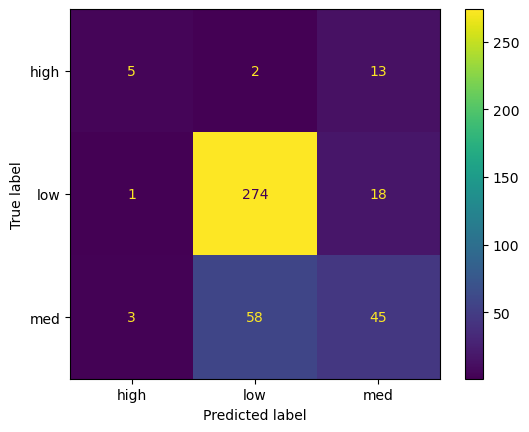

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Random Forest Classifier,0.656007,0.536561,0.571112,0.77327


In [29]:
# model 4 :random forest 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

# evaluate the random forest classifier
model_scores_rf = eval_classification(y_test, y_pred_rf, name='Random Forest Classifier', average='macro')
model_scores_rf 

[21:07:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier 

              precision    recall  f1-score   support

        high       0.64      0.45      0.53        20
         low       0.83      0.92      0.88       293
         med       0.61      0.45      0.52       106

    accuracy                           0.78       419
   macro avg       0.69      0.61      0.64       419
weighted avg       0.77      0.78      0.77       419



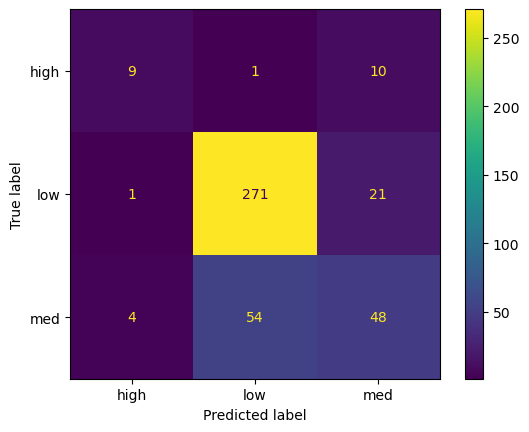

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
XGB Classifier,0.693913,0.609248,0.641312,0.782816


In [30]:
# model 5: xgb classifier
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf_pipe = make_pipeline(preprocessor, xgb_clf)
xgb_clf_pipe.fit(X_train, y_train)
xgb_clf_y_pred = xgb_clf_pipe.predict(X_test)

# evaluate the XGB classifier
model_scores_xgb_clf = eval_classification(y_test, xgb_clf_y_pred, name='XGB Classifier', average='macro')
model_scores_xgb_clf

Gradient Boosting Classifier 

              precision    recall  f1-score   support

        high       0.50      0.30      0.37        20
         low       0.84      0.92      0.87       293
         med       0.60      0.48      0.53       106

    accuracy                           0.78       419
   macro avg       0.65      0.57      0.59       419
weighted avg       0.76      0.78      0.76       419



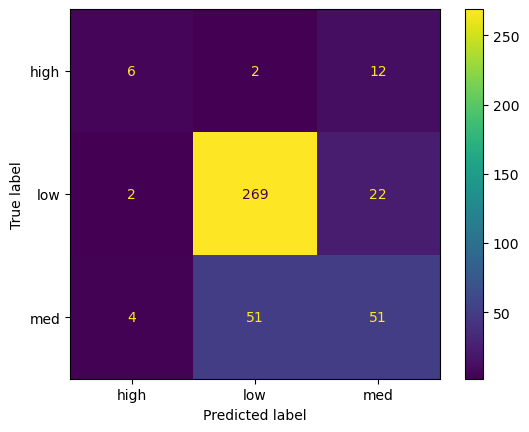

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Gradient Boosting Classifier,0.645135,0.566407,0.594609,0.778043


In [32]:
# model 6: gradient boost classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=42)
gb_clf_pipe = make_pipeline(preprocessor, gb_clf)
gb_clf_pipe.fit(X_train, y_train)
gb_clf_y_pred = gb_clf_pipe.predict(X_test)

# evaluate the gradient boost classifier
model_scores_gb_clf = eval_classification(y_test, gb_clf_y_pred, name='Gradient Boosting Classifier', average='macro')
model_scores_gb_clf

In [34]:
# combined scores of all our initial models
model_scores_combined = pd.concat([
    model_scores_log_reg,
    model_scores_knn,
    model_scores_dt,
    model_scores_rf,
    model_scores_xgb_clf,
    model_scores_gb_clf
])


model_scores_combined.reset_index(inplace=True)


print(model_scores_combined)

                     Model Name  Precision    Recall  F1 Score  Accuracy
0           Logistic Regression   0.664595  0.523455  0.559521  0.763723
1           K-Nearest Neighbors   0.625418  0.606584  0.606753  0.754177
2      Decision Tree Classifier   0.602814  0.573584  0.585112  0.737470
3      Random Forest Classifier   0.656007  0.536561  0.571112  0.773270
4                XGB Classifier   0.693913  0.609248  0.641312  0.782816
5  Gradient Boosting Classifier   0.645135  0.566407  0.594609  0.778043


### **Further Modeling and Evaluation (Hyperparameter Tuning)**

Given their strong(est) performance on the dataset, the RandomForest Regressor and XGB Regressor are the best candidates for further optimization using hyperparameter tuning and PCA. The results above suggest a very weak linear correlation which is why the two models performed best.

In [35]:
# parameter grids for the three models
log_reg_param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

rf_param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 20, 30, 40],
    'randomforestclassifier__min_samples_split': [2, 5, 10, 15],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
}

gb_param_grid = {
    'gradientboostingclassifier__n_estimators': [100, 200, 300, 400],
    'gradientboostingclassifier__max_depth': [3, 6, 9, 12],
    'gradientboostingclassifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'gradientboostingclassifier__subsample': [0.5, 0.75, 1],
    'gradientboostingclassifier__min_samples_split': [2, 5, 10, 15],
    'gradientboostingclassifier__min_samples_leaf': [1, 2, 4],
    'gradientboostingclassifier__max_features': ['auto', 'sqrt', 'log2'],
}

# pipelines for each model
log_reg_pipeline = make_pipeline(preprocessor, log_reg)
rf_pipeline = make_pipeline(preprocessor, rf)
gb_pipeline = make_pipeline(preprocessor, gb_clf)

# searching for hyperparameters 
n_iter_search = 800
log_reg_random_search = RandomizedSearchCV(log_reg_pipeline, param_distributions=log_reg_param_grid, n_iter=n_iter_search)
rf_random_search = RandomizedSearchCV(rf_pipeline, param_distributions=rf_param_grid, n_iter=n_iter_search)
gb_random_search = RandomizedSearchCV(gb_pipeline, param_distributions=gb_param_grid, n_iter=n_iter_search)

# fit the models with the random search
log_reg_random_search.fit(X_train, y_train)
rf_random_search.fit(X_train, y_train)
gb_random_search.fit(X_train, y_train)

# the best models
best_log_reg_model = log_reg_random_search.best_estimator_
best_rf_model = rf_random_search.best_estimator_
best_gb_model = gb_random_search.best_estimator_

Best Logistic Regression 

              precision    recall  f1-score   support

        high       0.62      0.25      0.36        20
         low       0.80      0.98      0.88       293
         med       0.68      0.32      0.44       106

    accuracy                           0.78       419
   macro avg       0.70      0.52      0.56       419
weighted avg       0.76      0.78      0.74       419



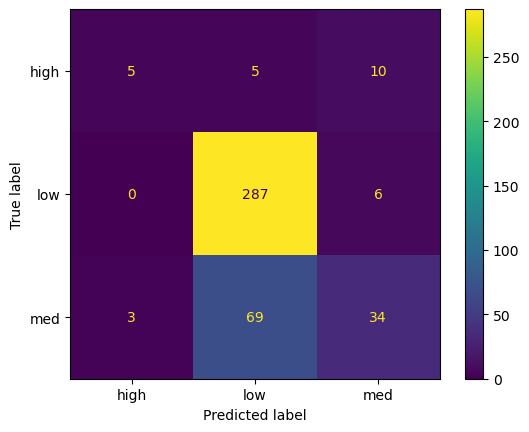

Best Random Forest 

              precision    recall  f1-score   support

        high       0.60      0.30      0.40        20
         low       0.81      0.94      0.87       293
         med       0.57      0.37      0.45       106

    accuracy                           0.76       419
   macro avg       0.66      0.54      0.57       419
weighted avg       0.74      0.76      0.74       419



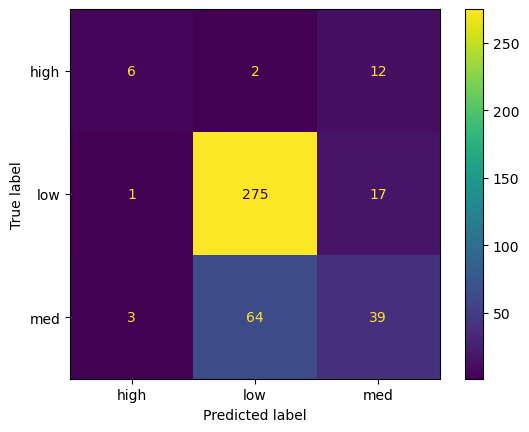

Best Gradient Boosting Classifier 

              precision    recall  f1-score   support

        high       0.71      0.50      0.59        20
         low       0.86      0.93      0.89       293
         med       0.67      0.56      0.61       106

    accuracy                           0.81       419
   macro avg       0.75      0.66      0.70       419
weighted avg       0.80      0.81      0.81       419



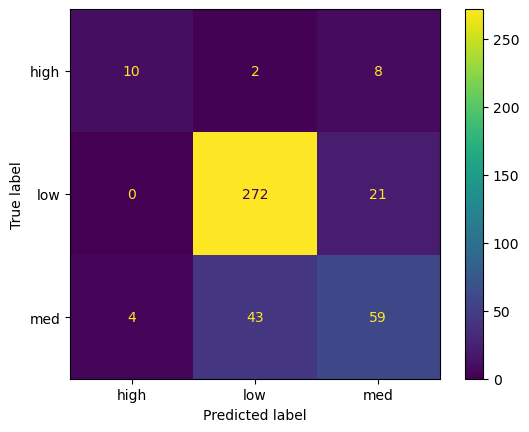

In [36]:
# evaluating our tuned models
best_log_reg_y_pred = best_log_reg_model.predict(X_test)
model_scores_best_log_reg = eval_classification(y_test, best_log_reg_y_pred, name='Best Logistic Regression', average='macro')


best_rf_y_pred = best_rf_model.predict(X_test)
model_scores_best_rf = eval_classification(y_test, best_rf_y_pred, name='Best Random Forest', average='macro')


best_gb_y_pred = best_gb_model.predict(X_test)
model_scores_best_gb = eval_classification(y_test, best_gb_y_pred, name='Best Gradient Boosting Classifier', average='macro')


In [37]:
# storing the evaluation results in a dataframe
results_df = pd.concat([model_scores_best_log_reg, model_scores_best_rf, model_scores_best_gb], axis=0).reset_index(drop=True)
results_df['Model Name'] = ['Tuned LogRegression', 'Tuned RandomForest', 'Tuned GradientBoost']
results_df

,Precision,Recall,F1 Score,Accuracy,Model Name
0,0.700005,0.516759,0.556905,0.778043,Tuned LogRegression
1,0.659994,0.535497,0.571928,0.763723,Tuned RandomForest
2,0.747595,0.661644,0.696095,0.813842,Tuned GradientBoost


In [38]:
# creating a dataframe out of both our gradient boost classifiers
gb_location = model_scores_combined[model_scores_combined['Model Name'] == 'Gradient Boosting Classifier'].index

tuned_gb_location = results_df[results_df['Model Name'] == 'Tuned GradientBoost'].index

gb_row = model_scores_combined.loc[gb_location]
tuned_gb_row = results_df.loc[tuned_gb_location]

comparison_df = pd.concat([gb_row, tuned_gb_row], ignore_index=True)
comparison_df

,Model Name,Precision,Recall,F1 Score,Accuracy
0,Gradient Boosting Classifier,0.645135,0.566407,0.594609,0.778043
1,Tuned GradientBoost,0.747595,0.661644,0.696095,0.813842


**Business Objective:** Accurate forecasting of Spanish wine ratings to ensure successful market introduction and positioning.

In selecting a model, our objective is to accurately predict the ratings (low, medium, or high) of Spanish wines entering a new market. Reliable predictions enable savvy business choices about the wines to invest in and promote, leading to potential increased sales and improved customer satisfaction.

The Tuned GradientBoost model outshines the base Gradient Boosting Classifier across all evaluated metrics, making it our preferred choice. The advancements in Precision, Recall, F1 Score, and Accuracy suggest that the Tuned GradientBoost model will deliver more reliable and accurate predictions.

Here are the key benefits of using the Tuned GradientBoost Classifier:

*Enhanced Precision:* Precision jumped from 0.645 to 0.747 in the Tuned GradientBoost model, meaning this model is more precise in predicting wines that will receive higher ratings. This precision enables you to focus on wines most likely to thrive in the new market, minimizing the risk associated with investing in wines that may not be well-received.

*Increased Recall:* A rise in Recall from 0.566 to 0.661 indicates that the Tuned GradientBoost model is more efficient at recognizing wines with truly positive ratings. This model can help you corner a larger market share of top-quality wines, leading to increased demand and customer satisfaction.

*Superior F1 Score:* The F1 Score combines Precision and Recall into a single metric for easy comparison. The score rose from 0.595 to 0.696 in the Tuned GradientBoost model, suggesting it provides a superior balance of Precision and Recall. This balance ensures more accurate and effective decision-making.

*Improved Accuracy:* The Tuned GradientBoost model boasts an Accuracy increase from 0.778 to 0.813. This higher Accuracy means the model's predictions are more often correct, leading to more strategic marketing decisions and better inventory management.

**Business Solution:**
In conclusion, our choice of the Tuned GradientBoost model will provide your business with more precise predictions, enabling you to optimize marketing efforts, manage inventory effectively, and invest wisely in wines with high potential. Ultimately, these informed decisions will boost sales, enhance customer satisfaction, and improve profitability.